# OMR project

The goal of this notebook is to play around with techniques to use in order to read a musical score from an image.
We will experiment multiple techniques, evaluate what we believe is best, and move forward.

In [1]:
import sys

# Add parent directory to Python PATH in order to allow imports from utils package
[lab_path] = ! pwd
if 'notebooks' in lab_path:
    sys.path.append("../src")
else:
    sys.path.append("src")
    
from utils.stopwatch import StopWatch
timer = StopWatch()

In [2]:
timer.start()

import os

import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from utils.display import display_img
from utils.im_utils import otsu_bin, remove_black_blocks
from sheet.staff_lines import remove_h_lines, remove_v_lines

timer.stop("Finished imports")

Finished imports - 1094.13ms


In [3]:
DATA_PATH="data"
if 'notebooks' in lab_path:
    DATA_PATH = "../data"

In [4]:
supported_img_extensions = ["png", "jpg"]
sample_files = [file for file in os.listdir(DATA_PATH) if file[-3:] in supported_img_extensions]
sample_files

['imagine.png',
 'fire.jpg',
 'lost.jpg',
 '2020-04-11 22.16.28.jpg',
 'sheet.jpg',
 'old_town_road.png',
 'Moonlight Shadow Flauta-1.png',
 'VarnattstankarvidFridasruta.jpg',
 'races.png']

In [5]:
timer.start()
SELECTED_FILE = 2

gray_img = cv2.imread(os.path.join(DATA_PATH, sample_files[SELECTED_FILE]), 0)   
timer.lap(f"Loaded grayscale image with shape {gray_img.shape}")

bin_img = otsu_bin(gray_img)
timer.stop("Binarized image")

height, width = gray_img.shape

# display_img(bin_img, "Bin image")

Loaded grayscale image with shape (3508, 2479) - 26.92ms
Binarized image - 105.71ms


## RLE encoding our image

Ok so now that we binarized our image, we should be left with pixels with value 0 or 1. Some calculations will be more efficient on a compressed image. A common technique is to use Run Length Compression (RLC) to do that. 

In [6]:
from utils.rle import rl_encode_2D, rl_decode_2D

timer.start()
rle, rl_values = rl_encode_2D(bin_img)
timer.stop("Done with Run-Length encoding")

Done with Run-Length encoding - 625.07ms


## Finding essential dimensions

Here we will sum consecutive pairs of RLE, then find most common value to evaluate line thickness and spacing.
This technique was validated by Pinto et al. in [1] as being the most commonly used.

[1] Pinto et al. - http://www.inescporto.pt/~jsc/publications/conferences/2011TPintoIbPRIA.pdf

In [7]:
from utils.rle_caracteristics import get_consecutive_sum, get_most_common_consec_sum, get_sum_components, get_characteristics

In [8]:
# Let's try separating line thickness from spacing now.
# We have the entity as a sum, let's see the separate components of this sum.

timer.start()
most_common = get_most_common_consec_sum(rle)
timer.lap(f"Most common consec sum is {most_common}")
line_thickness, line_spacing, _ = get_characteristics(rle, most_common)
timer.stop(f"Line thickness seems to be {line_thickness}, while line spacing is {line_spacing}.")

Most common consec sum is 21 - 47.00ms
Line thickness seems to be 3, while line spacing is 18. - 135.55ms


In [9]:
timer.start()
no_staff_line_image = remove_h_lines(bin_img, line_thickness)
timer.lap("Removed staff lines from image")
no_v_line_image = remove_v_lines(no_staff_line_image, line_thickness)
timer.stop("Removed v lines from image")

# display_img(no_v_line_image, title="No vertical lines nor horizontal lines")

Removed staff lines from image - 1164.45ms
Removed v lines from image - 2014.92ms


## Edge detection

To detect edges in our image, we can obviously use a Canny filter. 

However, to detect horizontal lines, applying a derivative along the y axis mignt work as well, using a Sobel filter. We will test both methods out.

Both methods seem to work very well. We will use Canny filter for now, as it is quite faster than our Sobel-Y implementation.

In [10]:
# Canny filter method
timer.start()
canny_prep_image = 255*(abs(bin_img - no_staff_line_image)).astype(np.uint8)

edges = cv2.Canny(canny_prep_image,100,200)

timer.stop("Executed Canny filter")
# display_img(edges, title="Canny filter applied to image")

Executed Canny filter - 54.43ms


## Defining interest zones

We will now define interest zones. We would like to trace a rectangle around this interest zone.

At first, these rectangle will be as wide as the music sheet is.

To define top and bottom boundaries, of each zone, we look at the lines detected by Hough Transform line detection, and keep only the top and bottom line of each group. We do this using the fact that they are in groups of 5 lines, and that the distance between the top and bottom line is bigger than 4 times line spacing (because of line thickness). We can then evaluate distance between two groups, find the center of a line grouping, and trace rectangles with sufficient padding. 

It is important to note that no arbitrary values have been used here. Finding these groups is only based on characteristics of the image.

In [11]:
from sheet.zones import get_interest_zones, draw_zones_on_image

Found interest zones in our image - 66.62ms
Drew all on canvas - 0.99ms
Image rendering done - 155.26ms


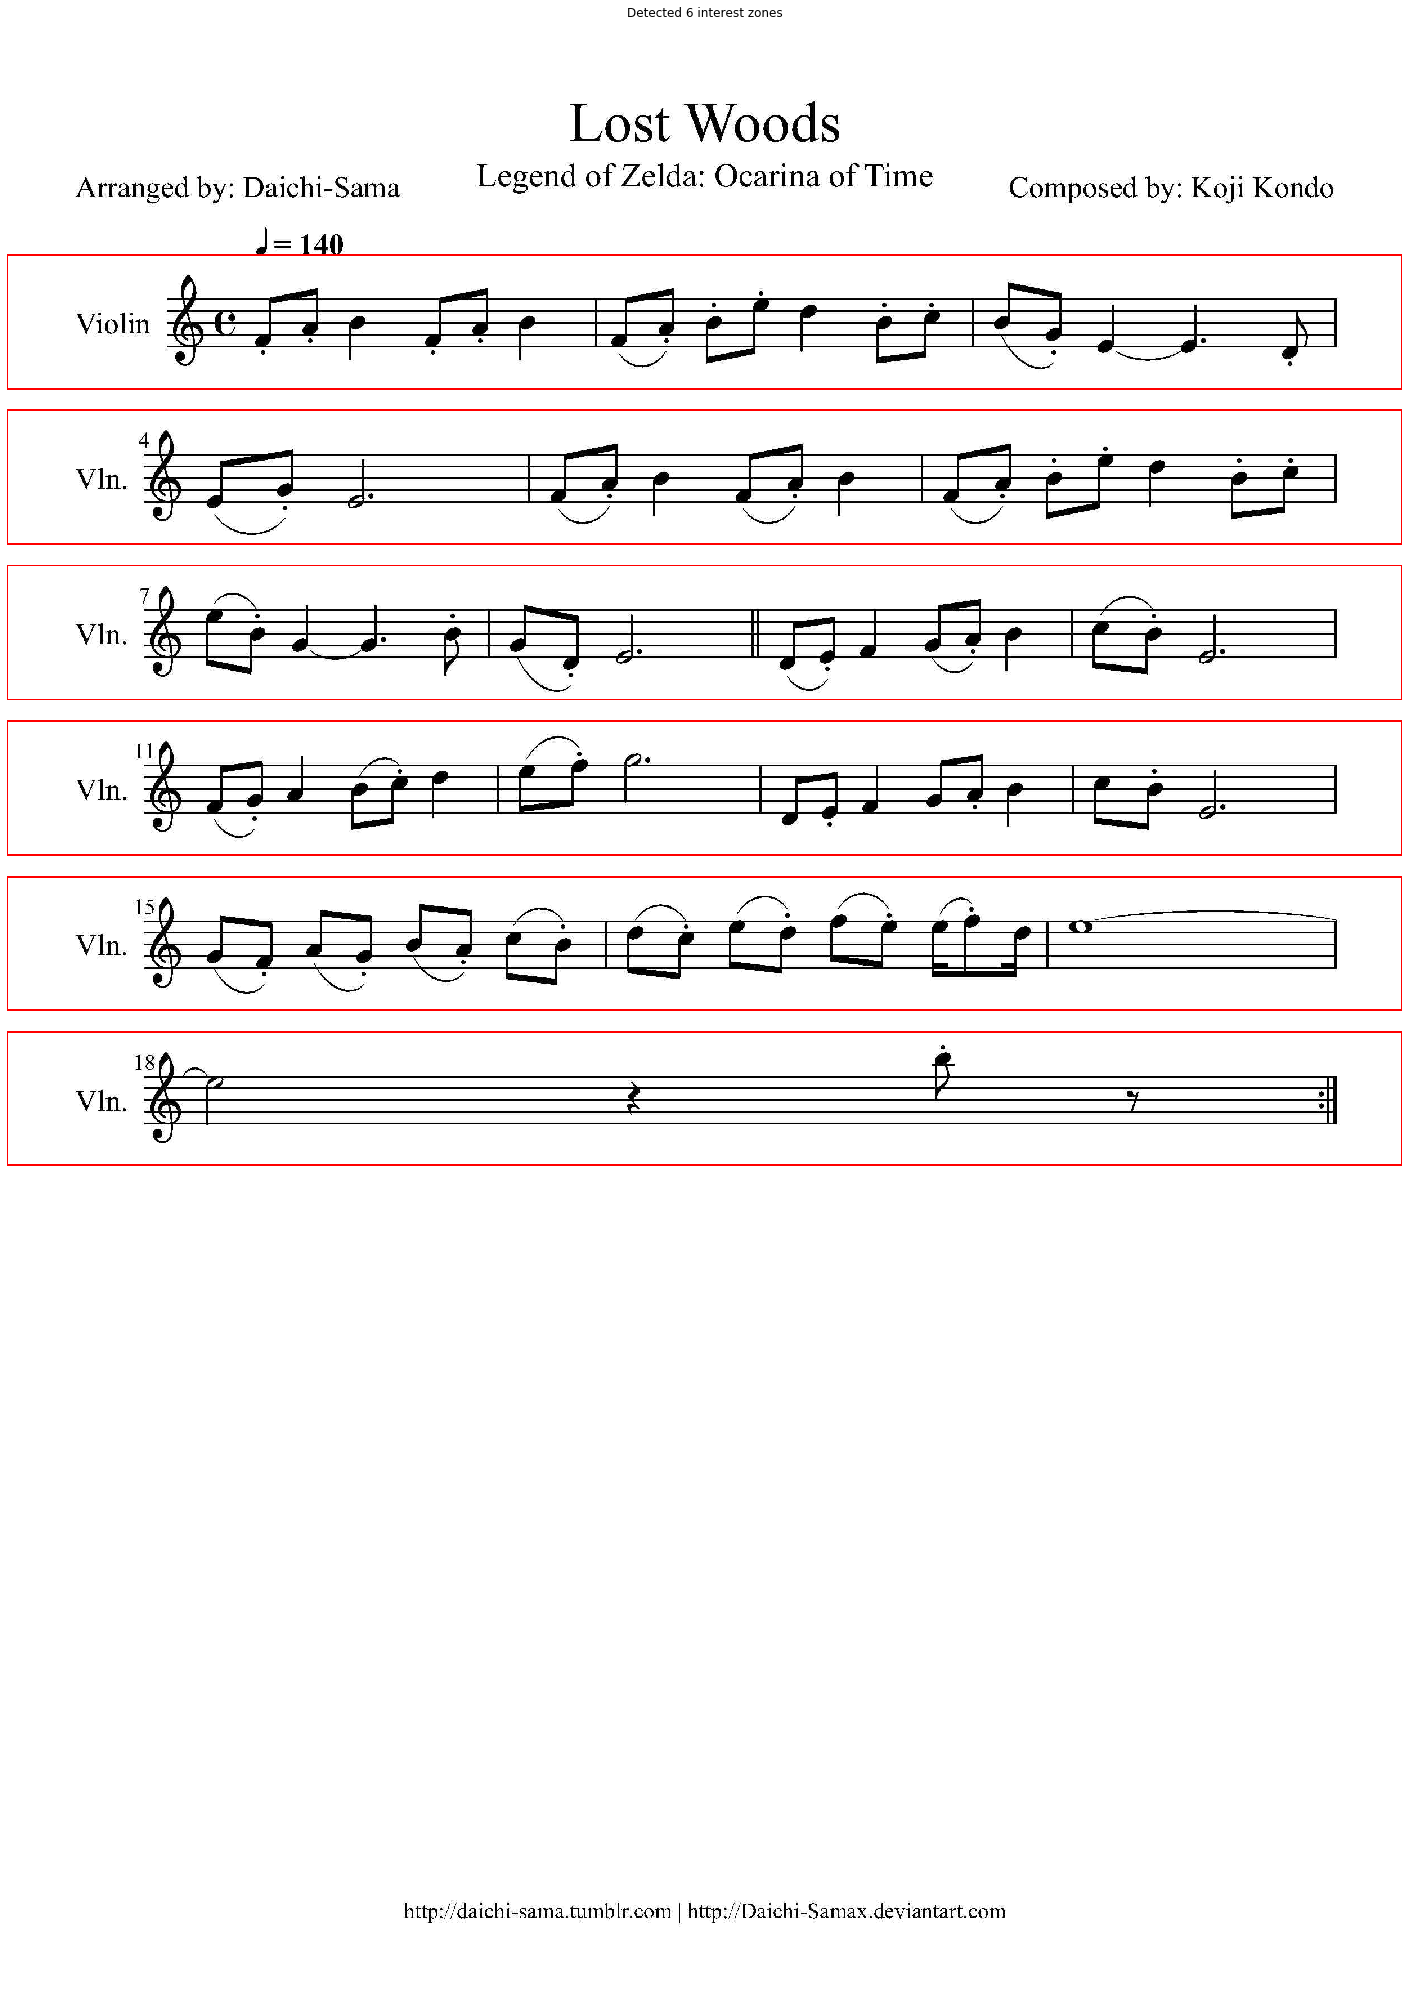

In [12]:
color_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
timer.start()

interest_zones, lines = get_interest_zones(edges, line_spacing, im_width=width, return_lines=True)

timer.lap("Found interest zones in our image")

 
draw_zones_on_image(color_img, interest_zones)  
timer.lap("Drew all on canvas")

display_img(color_img, title=f"Detected {len(interest_zones)} interest zones")
timer.stop("Image rendering done")

## Detecting symbols on the music sheet - Clustering pixels into notes

Hough ellipsis detection does not seem to be very time efficient. We will now try a different approach, by considering notes (especially quarters, eigths...) as clusters of black pixels. Let's see how a clustering approach works for note detection !

### Clustering

We use DBScan clustering algorithm here to figure out pixel clusters in our image, after removal of both staff lines and vertical lines. 

We then filter the results based on some basic rules on the aspect of note heads:
- their height is about the same as the line spacing
- their width is seldom bigger than twice the line spacing
- they are wider than they are high

In [13]:
from utils.im_utils import get_black_pixels_in_interest_zones
from utils.clustering import get_note_clusters

In [14]:
timer.start()
X = get_black_pixels_in_interest_zones(no_v_line_image, interest_zones) 
timer.stop("Got pixel coordinates in img without vertical lines")

Got pixel coordinates in img without vertical lines - 63.33ms


Isolated note clusters with DBSCAN - 1051.60ms
Drew all on canvas - 8.06ms
Image rendering done - 1139.96ms


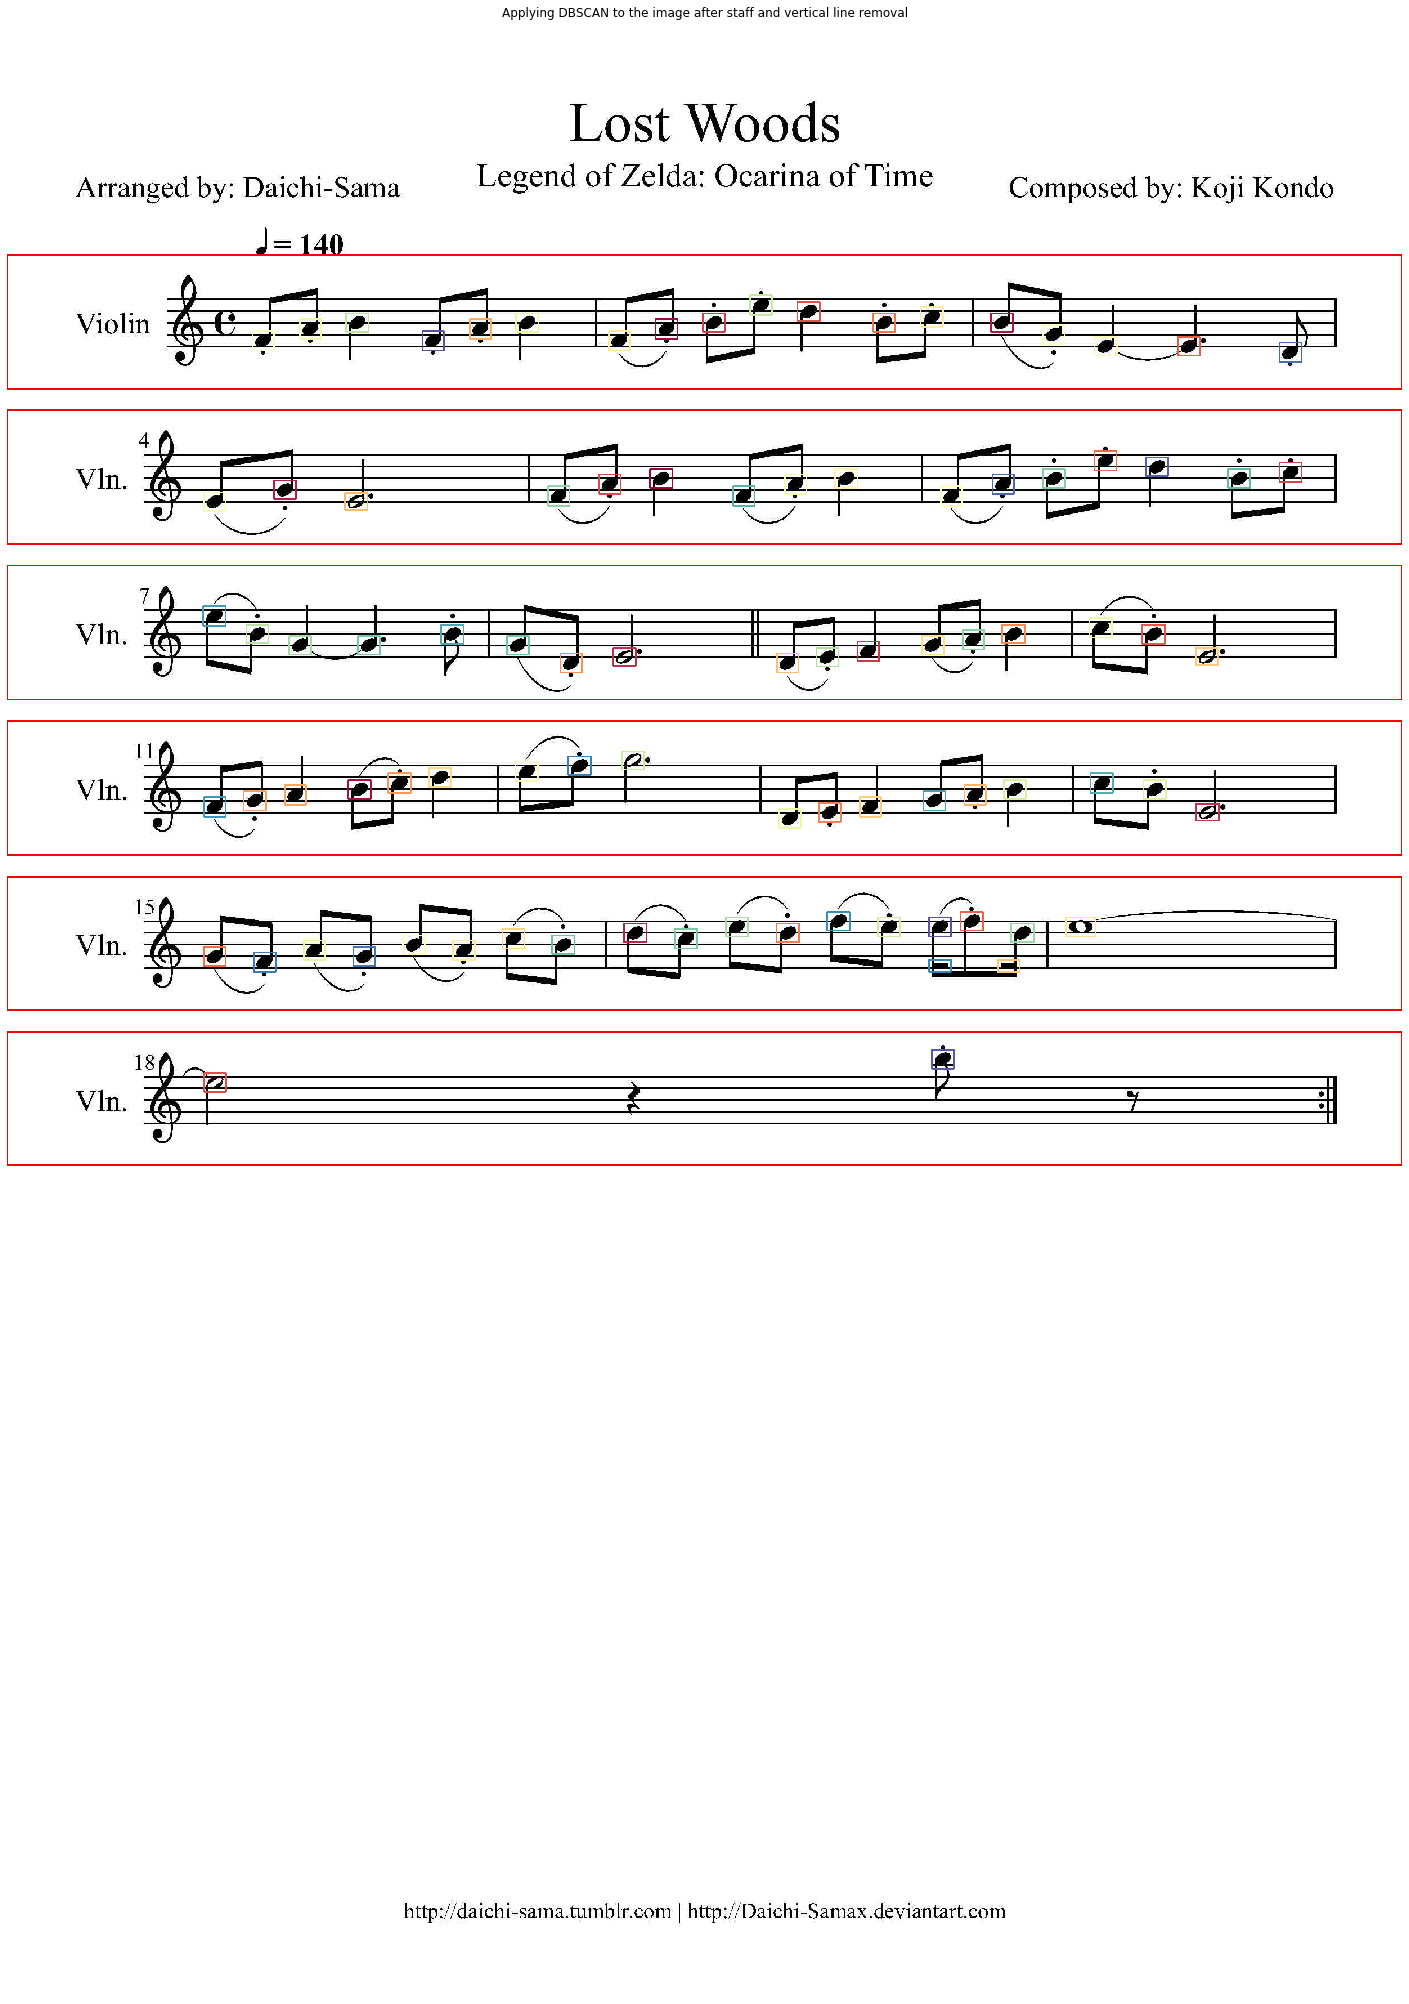

In [15]:
color_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
timer.start()
clusters = get_note_clusters(X, line_thickness, line_spacing, eps=1.5*line_thickness)
timer.lap("Isolated note clusters with DBSCAN")

colors = np.array([plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(clusters))])[:, :-1]*255
np.random.shuffle(colors)

padding = 2*line_thickness
for index, cluster in enumerate(clusters):
    color = colors[index]
    cv2.rectangle(
        color_img, 
        (cluster.bounds.left-padding, cluster.bounds.top-padding), 
        (cluster.bounds.right+padding, cluster.bounds.bottom+padding), 
        color, 
        2
    )

draw_zones_on_image(color_img, interest_zones)
timer.lap("Drew all on canvas") 

display_img(color_img, title="Applying DBSCAN to the image after staff and vertical line removal") 
timer.stop("Image rendering done") 


## Converting clusters to notes

Now that we managed to identify note heads on our music sheet, we need to translate this into a musical note, not just coordinates of pixels.
To do this, we build a grid of horizontal lines, that each correspond to a note height writable on the music sheet (i.e. C, D, E, F, G, A, B). 

We then compute the distance of a notehead to these lines. The closes match corresponds to the note height for this note head.

In [16]:
from sheet.zones import get_grid_by_zone

In [17]:
timer.start()
spacer = (line_spacing + line_thickness)/2

grids = get_grid_by_zone(interest_zones, lines, spacer)
    
timer.stop("Built grid to match notes in each zone")

Built grid to match notes in each zone - 0.89ms


In [18]:
color_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
colors = np.array([plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(interest_zones))])[:, :-1]*255

timer.start()
for zone in interest_zones:
    top, bottom, left, right = zone.de_struct()
    cv2.rectangle(color_img, (left, top), (right, bottom), (255,0,0), 2)
    
timer.lap("Drew zones")
for index, grid in enumerate(grids):
    for line in grid.h_lines:
        cv2.line(color_img,(0,line),(width,line),colors[index],2)
timer.stop("Drew lines")  

# display_img(color_img, title=f"Drew grid in interest zones")

Drew zones - 0.46ms
Drew lines - 3.09ms


Now, we would like to map a note to each line. to do this, we could in the grid-producing process, know that the first original line corresponds to the "F" on the top staff line. We did that, adding a note_range array returned, containing the MIDI codes of the notes corresponding to each line.

In [19]:
from utils.clustering import clusters_to_notes

In [20]:
timer.start()

note_heads_by_zone = clusters_to_notes(clusters, interest_zones, grids)

timer.stop("Converted all clusters to NoteHeads with proper note height")  

Converted all clusters to NoteHeads with proper note height - 30.34ms


In [21]:
from utils.midi import save_notes_to_midi_files, play_midi, stop_midi

timer.start()
note_succession = save_notes_to_midi_files(note_heads_by_zone)
timer.stop("Saved notes to midi files")

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
Saved notes to midi files - 2.29ms


In [22]:
play_midi()

In [23]:
stop_midi()

## Detecting rythm

In order to detect the rythm to play for each note (full, half, quarter, eights...) we will... Find an innovative method !

### Differentiate full notes from white ones

To do this, we will compute the mean pixel density in a cluster. Clusters above mean are full notes, others are white ones.

In [24]:
from utils.notes import separate_full_note_heads, separate_full_from_halves

In [25]:
timer.start()
note_heads_by_zone = separate_full_note_heads(note_heads_by_zone)
timer.lap("Separated full note heads")
note_heads_by_zone = separate_full_from_halves(note_heads_by_zone)
timer.stop("Separated full, halves and quarters")

Pixel density | mean: 0.8537733581440554 | median: 0.7592592592592593
Separated full note heads - 1.01ms
Note head length | mean: 27.285714285714285 | median: 33.0
Separated full, halves and quarters - 1.26ms


In [26]:
timer.start()
note_succession = save_notes_to_midi_files(note_heads_by_zone)
timer.stop("Saved notes to midi files")

play_midi()

Saved notes to midi files - 4.56ms


In [27]:
stop_midi()

Let's display all that now, in a nice colored way !

Colorized pixels - 62.70ms


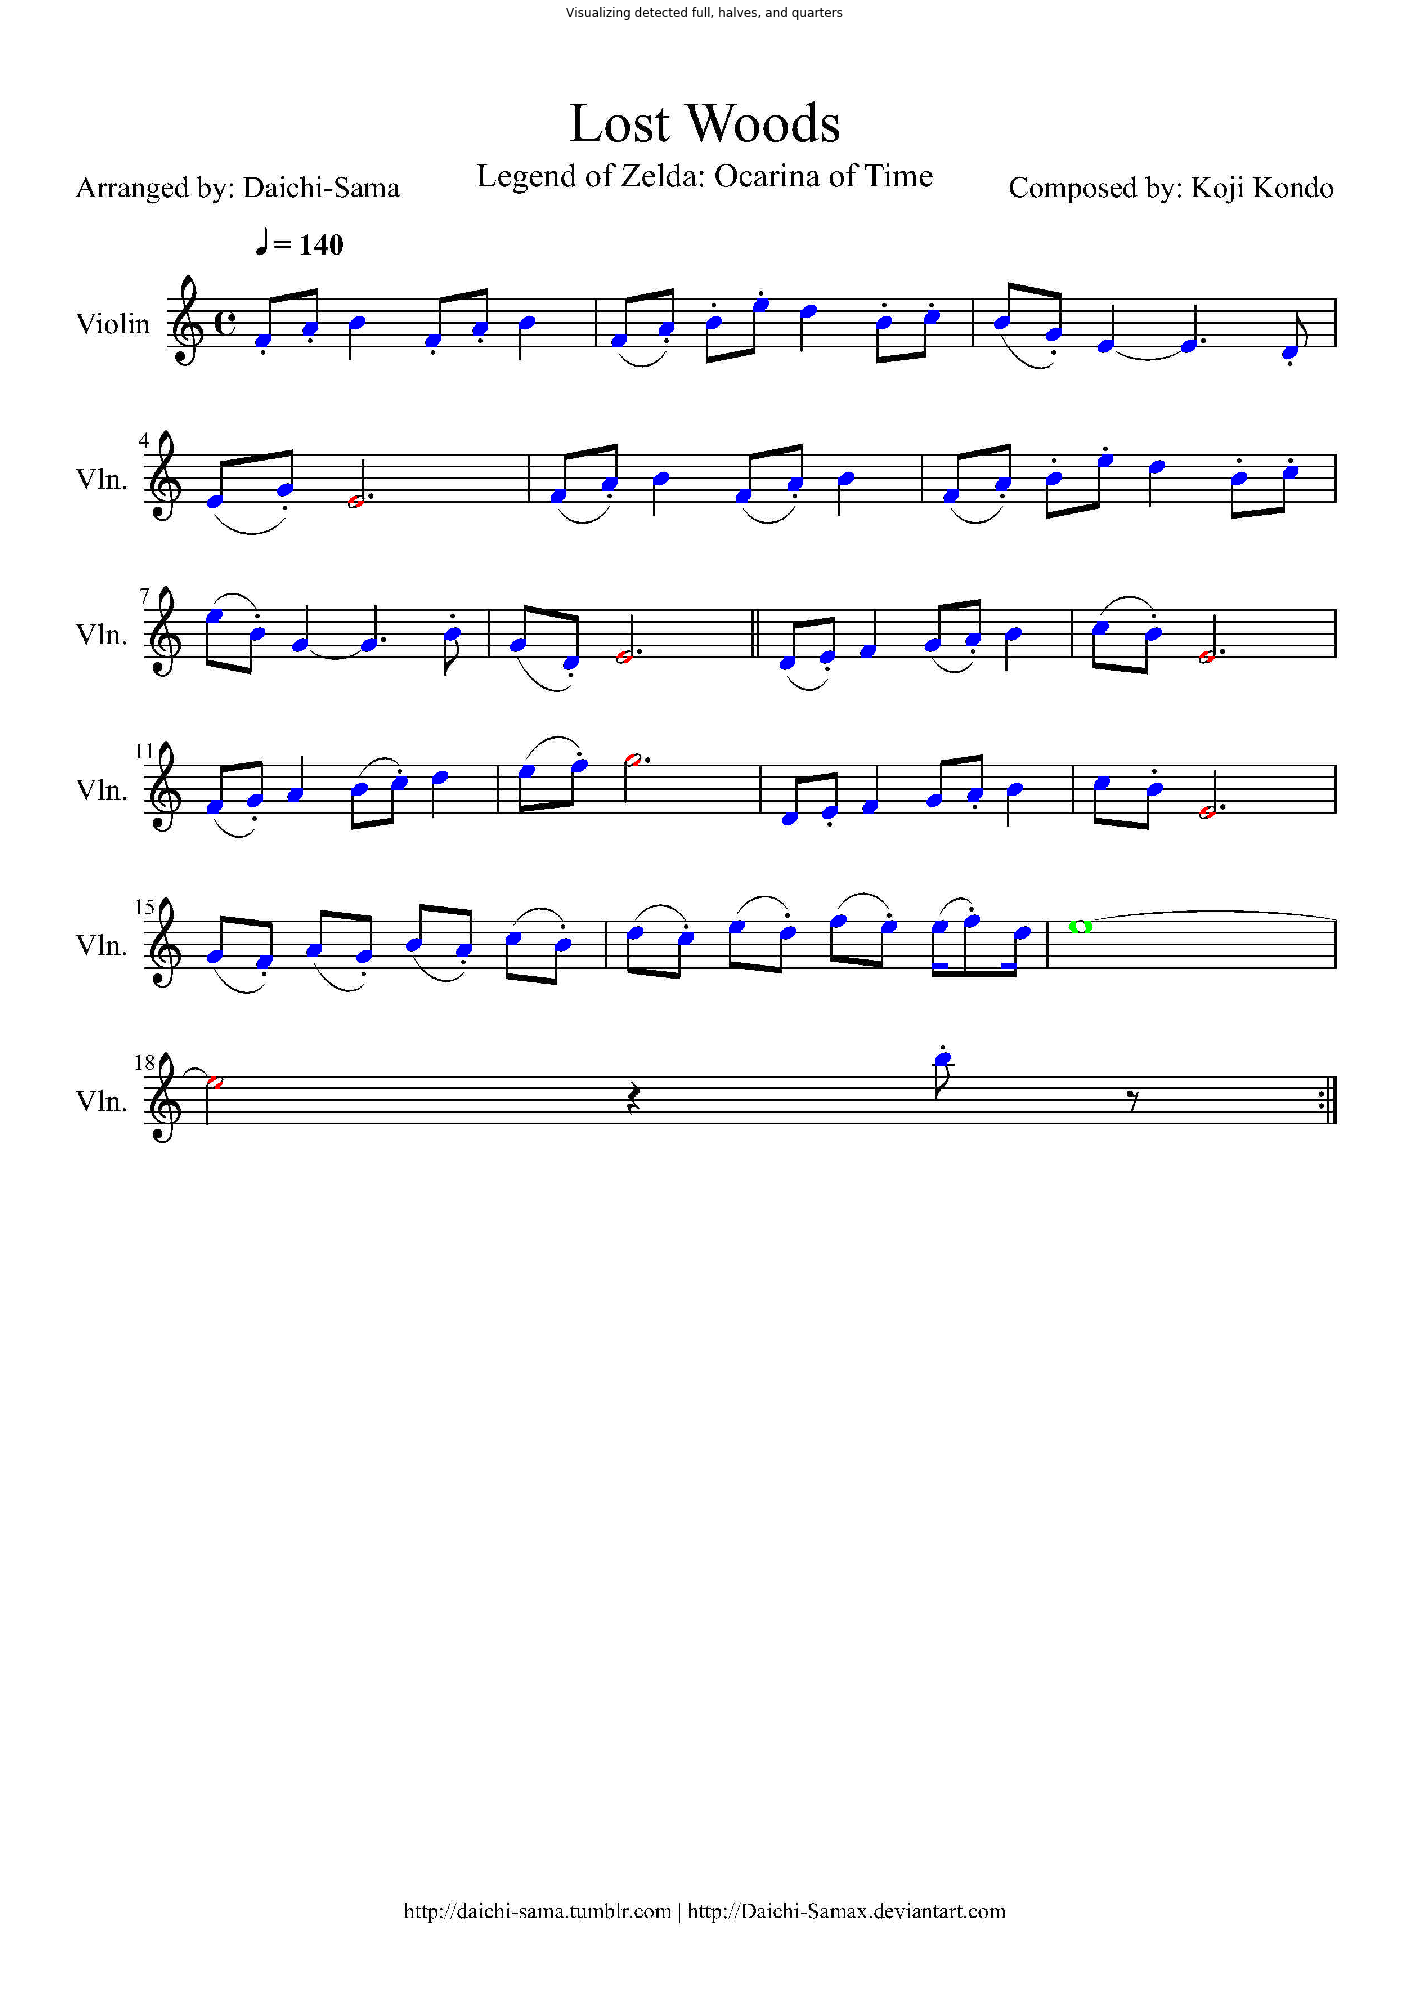

In [28]:
x, y = gray_img.shape
note_head_image = np.ones((x, y, 3))
note_head_image = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)

timer.start()
for zone in note_heads_by_zone:
    for note_head in zone:
        for px in note_head.pixels:
            if note_head.rhythm == 2:
                note_head_image[px[0], px[1]] = (0, 0, 255)
            elif note_head.rhythm == 0.5:
                note_head_image[px[0], px[1]] = (0, 255, 0)
            else:
                note_head_image[px[0], px[1]] = (255, 0, 0)
timer.stop("Colorized pixels")

display_img(note_head_image, title="Visualizing detected full, halves, and quarters")

# Fine grained note characteristics

Now, let's find note characteristics from their context.

In [29]:
from sheet.zones import refine_zones_with_notes
from music.group import Group

In [30]:
timer.start()
zones_with_notes = refine_zones_with_notes(note_heads_by_zone, interest_zones, line_spacing, im_width=width)
timer.stop("Refined interest zones around notes")

Refined interest zones around notes - 0.38ms


In [31]:
timer.start()
pixel_coords = get_black_pixels_in_interest_zones(no_staff_line_image, zones_with_notes) 
timer.stop("Got pixel coordinates for img without staff lines")

Got pixel coordinates for img without staff lines - 93.23ms


In [32]:
from utils.clustering import get_note_group_clusters
timer.start()

note_groups = get_note_group_clusters(pixel_coords, line_spacing, eps=line_spacing)
timer.stop(f"Found {len(note_groups)} note groups")

Found 60 note groups - 1934.03ms


In [33]:
timer.start()
for zone in note_heads_by_zone:
    for note_head in zone:
        note_assigned = False
        for index, group in enumerate(note_groups):
            if group.includes_note(note_head):
                break
timer.stop("Assigned notes to groups")

Assigned notes to groups - 158.25ms


In [34]:
for group in note_groups:
    if len(group.note_heads) > 1:
        for note in group.note_heads:
            # Say all notes in groups of notes whith more than 1 note
            # are quarters (at least, they migtht be eights)
            if note.rhythm == 2:
                note.set_rhythm(note.rhythm*2)

Drew a total of 60 groups - 39.16ms
Image rendering is done - 111.62ms


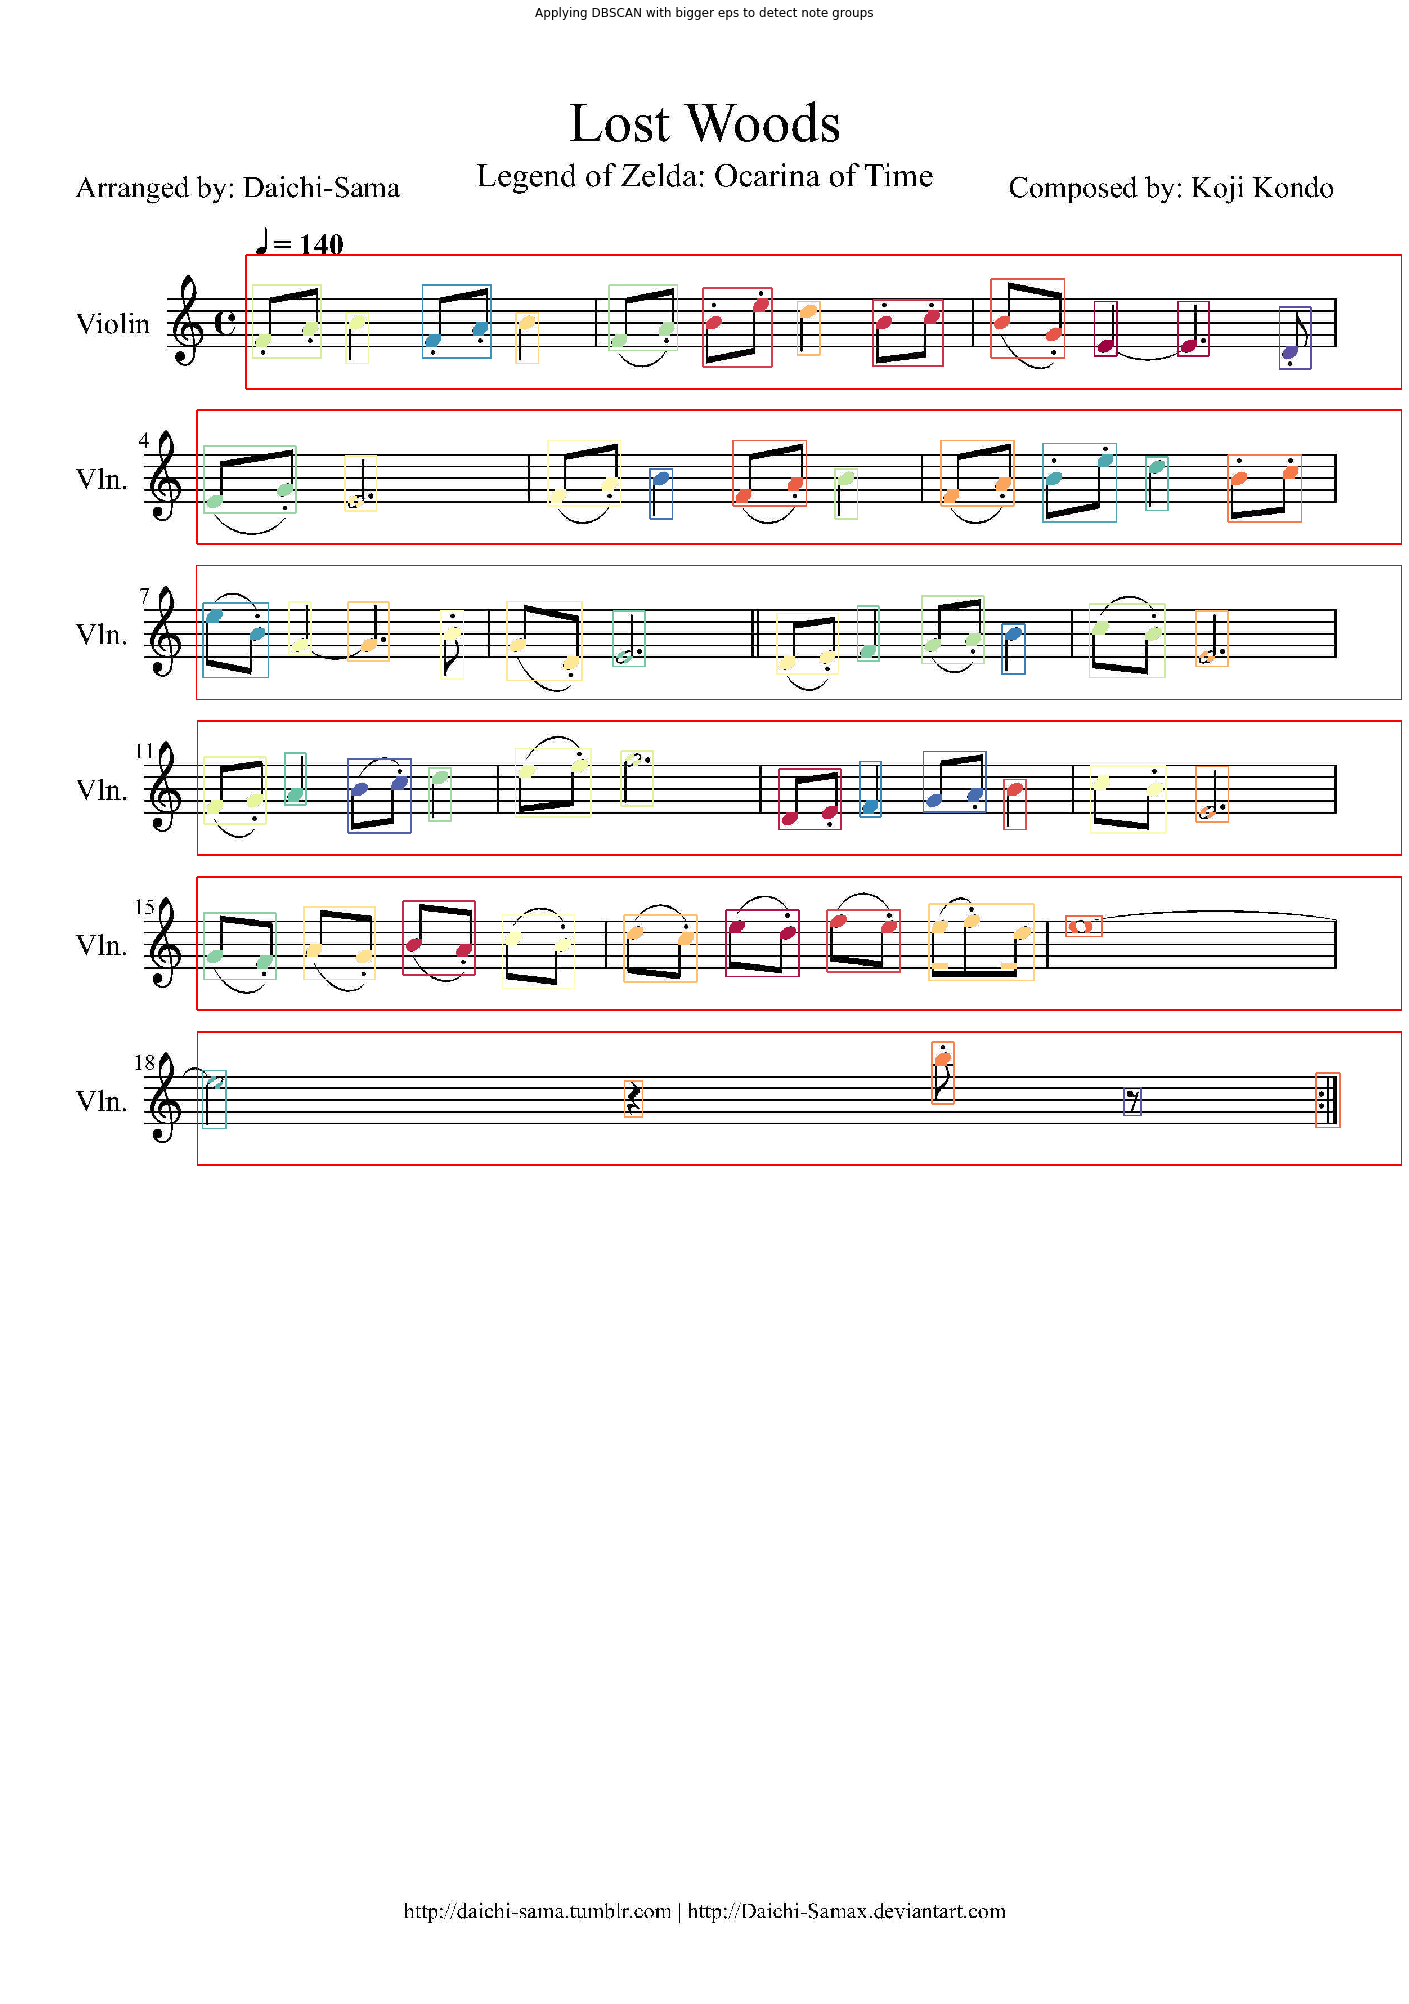

In [35]:
# Display logic
color_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
colors = np.array([plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(note_groups))])[:, :-1]*255
np.random.shuffle(colors)

def color_pixels_on_image(pixels, image, color=(255,0,0)):
    for px in pixels:
        image[px[0], px[1]] = color

def color_bounds_on_img(bounds, image, padding=2, color=(255, 0, 0)):
    cv2.rectangle(
        color_img, 
        (bounds.left-padding, bounds.top-padding), 
        (bounds.right+padding, bounds.bottom+padding), 
        color, 
        2
    )

timer.start()
for index, group in enumerate(note_groups):
    for note in group.note_heads:
        color = (255, 0, 0)
        if note.rhythm < 1:
            color = (255, 255, 0)
        elif note.rhythm == 1:
            color = (0, 255, 255)
        elif note.rhythm == 2:
            color = (255, 0, 255)
        elif note.rhythm == 4:
            color = (0, 0, 255)
        else:
            print(f"weird rhythm: {note.rhythm}")
        color_pixels_on_image(note.pixels, color_img, colors[index])
            
padding = 2*line_thickness
for index, group in enumerate(note_groups):
    color_bounds_on_img(group.bounds, color_img, padding=padding, color=colors[index])

draw_zones_on_image(color_img, zones_with_notes)
timer.lap(f"Drew a total of {len(note_groups)} groups")

display_img(color_img, title="Applying DBSCAN with bigger eps to detect note groups")
timer.stop(f"Image rendering is done")


In [36]:
from utils.clustering import groups_to_notes_by_zone

In [37]:
notes_by_zone = groups_to_notes_by_zone(note_groups, interest_zones)

In [38]:
timer.start()
note_succession = save_notes_to_midi_files(notes_by_zone)
timer.stop("Saved notes to midi files")

play_midi()

Saved notes to midi files - 2.81ms


In [39]:
stop_midi()

## Differentiating single quarters

In [40]:
densities = np.fromiter(filter(lambda x: x >= 0, [group.single_no_head_nor_tail_density() for group in note_groups]), dtype=np.float64)

mean_pixel_density = densities.mean()
median_pixel_density = (densities.max() + densities.min()) / 2
quartile_pixel_density = (densities.max() + densities.min()) / 4

print(f"Pixel density | mean: {mean_pixel_density} | median: {median_pixel_density}")
densities.max()

Pixel density | mean: 0.028260284692949788 | median: 0.08560090702947845


0.1712018140589569

In [41]:
timer.start()    

total = 0
for group in note_groups:
    if group.is_single_quarter(threshold=quartile_pixel_density):
        total += 1
    
timer.stop(f"Found a total of {total} single quarter notes on the score")

Found a total of 3 single quarter notes on the score - 121.53ms


Drew a total of 60 groups - 60.74ms
Image rendering is done - 125.67ms


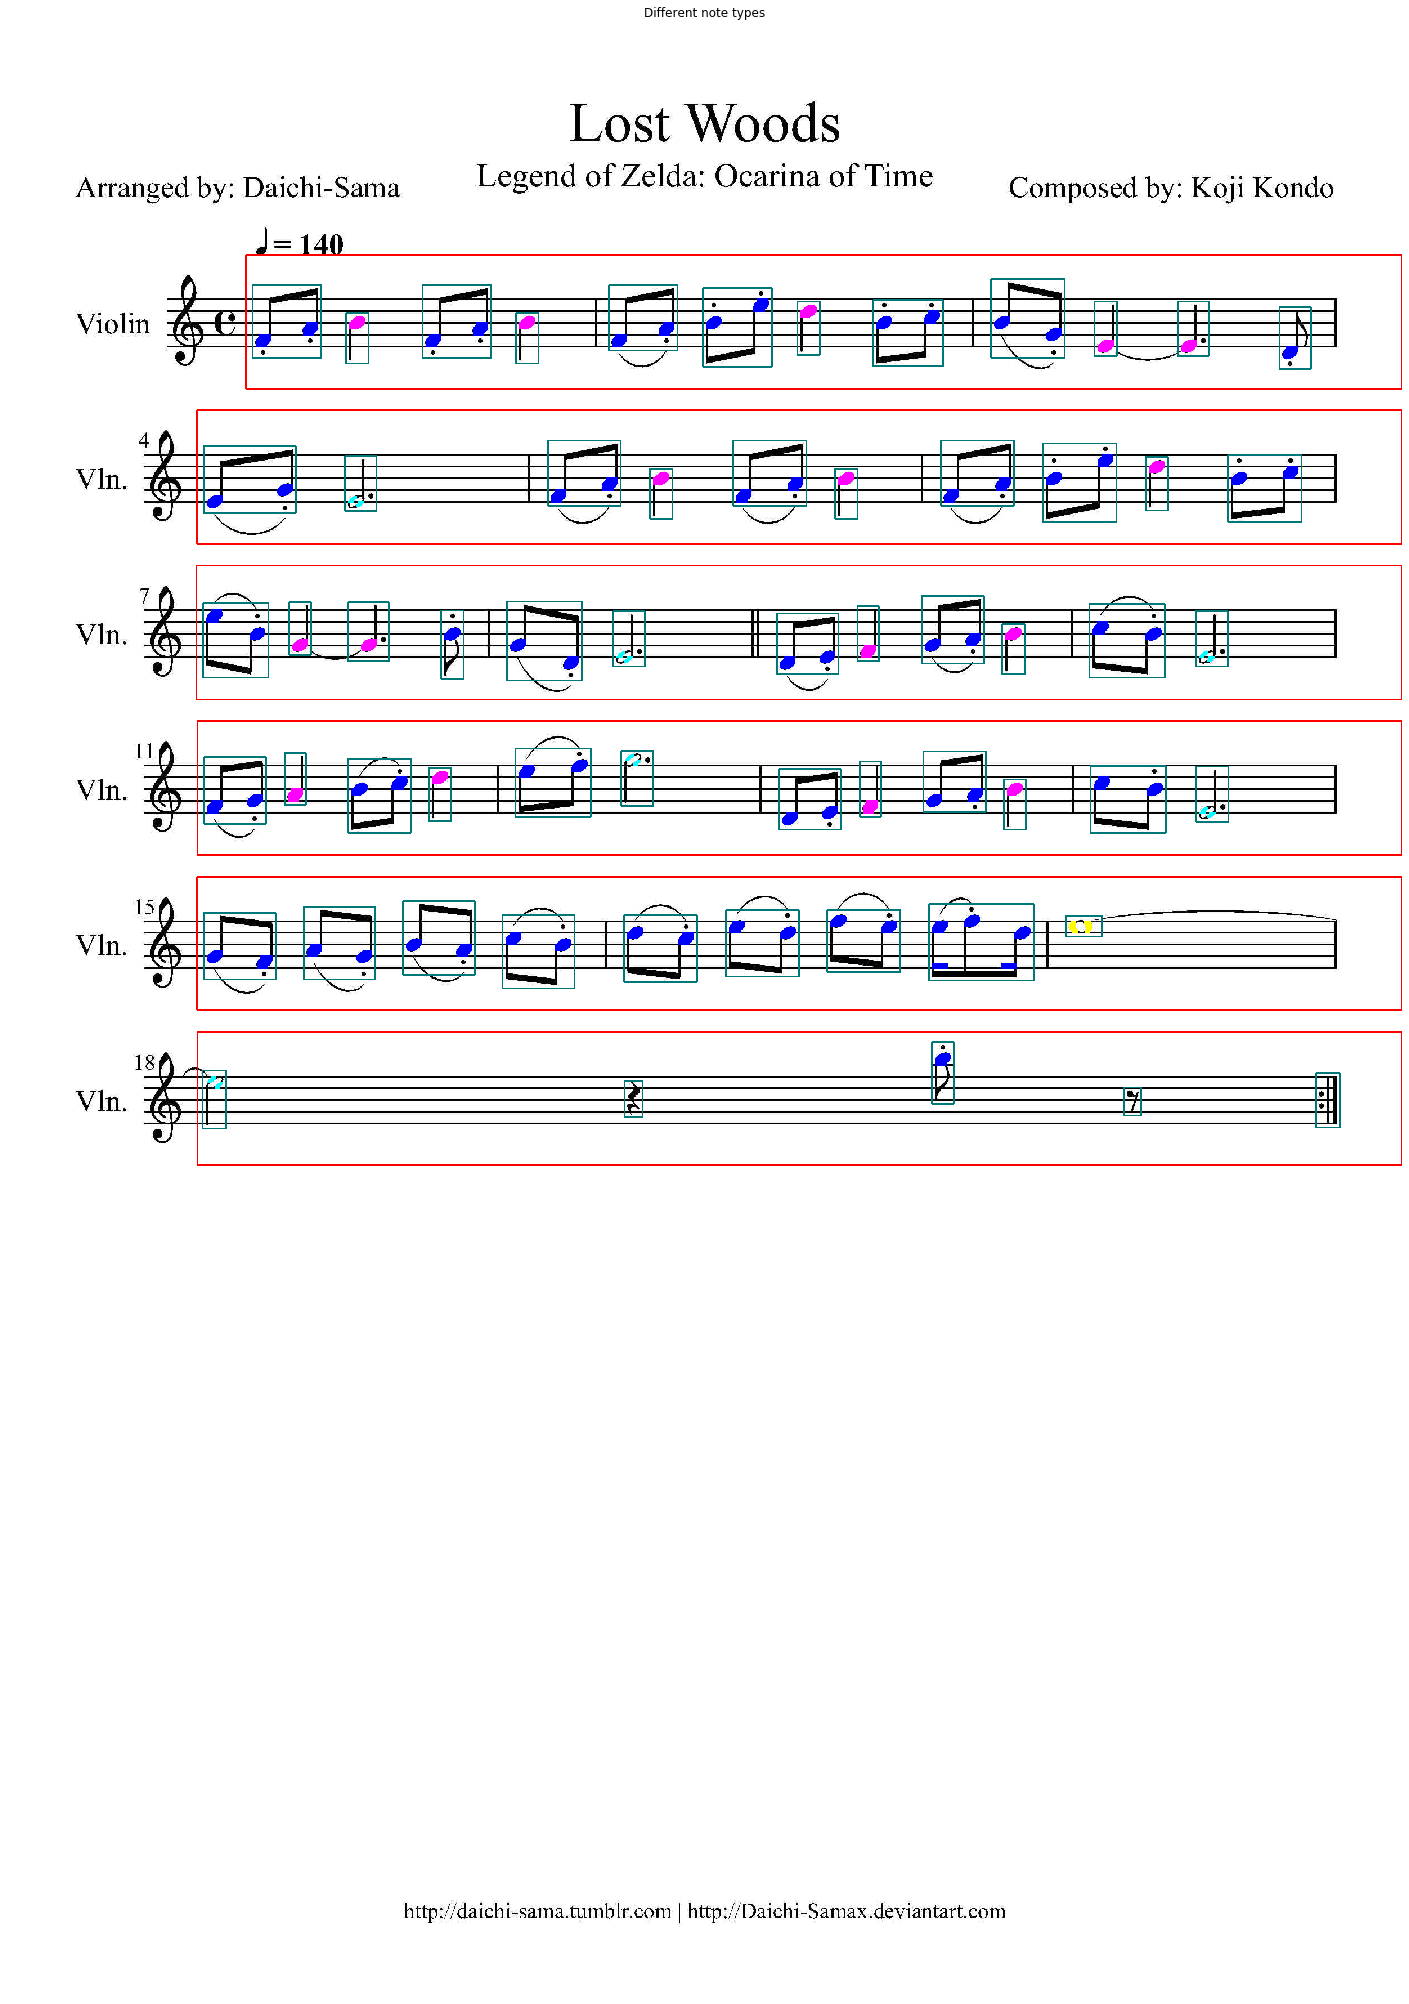

In [42]:
# Display logic
color_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
colors = np.array([plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(note_groups))])[:, :-1]*255
np.random.shuffle(colors)

head_colors = np.array([plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 7)])[:, :-1]*255
np.random.shuffle(head_colors)

timer.start()
for index, group in enumerate(note_groups):
    for note in group.note_heads:
        color = (255, 0, 0)
        if note.rhythm < 1:
            color = (255, 255, 0)
        elif note.rhythm == 1:
            color = (0, 255, 255)
        elif note.rhythm == 2:
            color = (255, 0, 255)
        elif note.rhythm == 4:
            color = (0, 0, 255)
        else:
            print(f"weird rhythm: {note.rhythm}")
        color_pixels_on_image(note.pixels, color_img, color)
            
padding = 2*line_thickness
for index, group in enumerate(note_groups):
    color_bounds_on_img(group.bounds, color_img, padding=padding, color=(0, 120, 120))

draw_zones_on_image(color_img, zones_with_notes)
timer.lap(f"Drew a total of {len(note_groups)} groups")

display_img(color_img, title="Different note types")
timer.stop(f"Image rendering is done")

## Now to handle dotted notes

In [43]:
timer.start()

total = 0
for group in note_groups:
    total += group.handle_dotted_notes(neighbourhood=line_spacing)
    
timer.stop(f"Found a total of {total} dotted notes on the score")

Found a total of 7 dotted notes on the score - 222.74ms


Drew a total of 60 groups - 38.48ms
Image rendering is done - 107.28ms


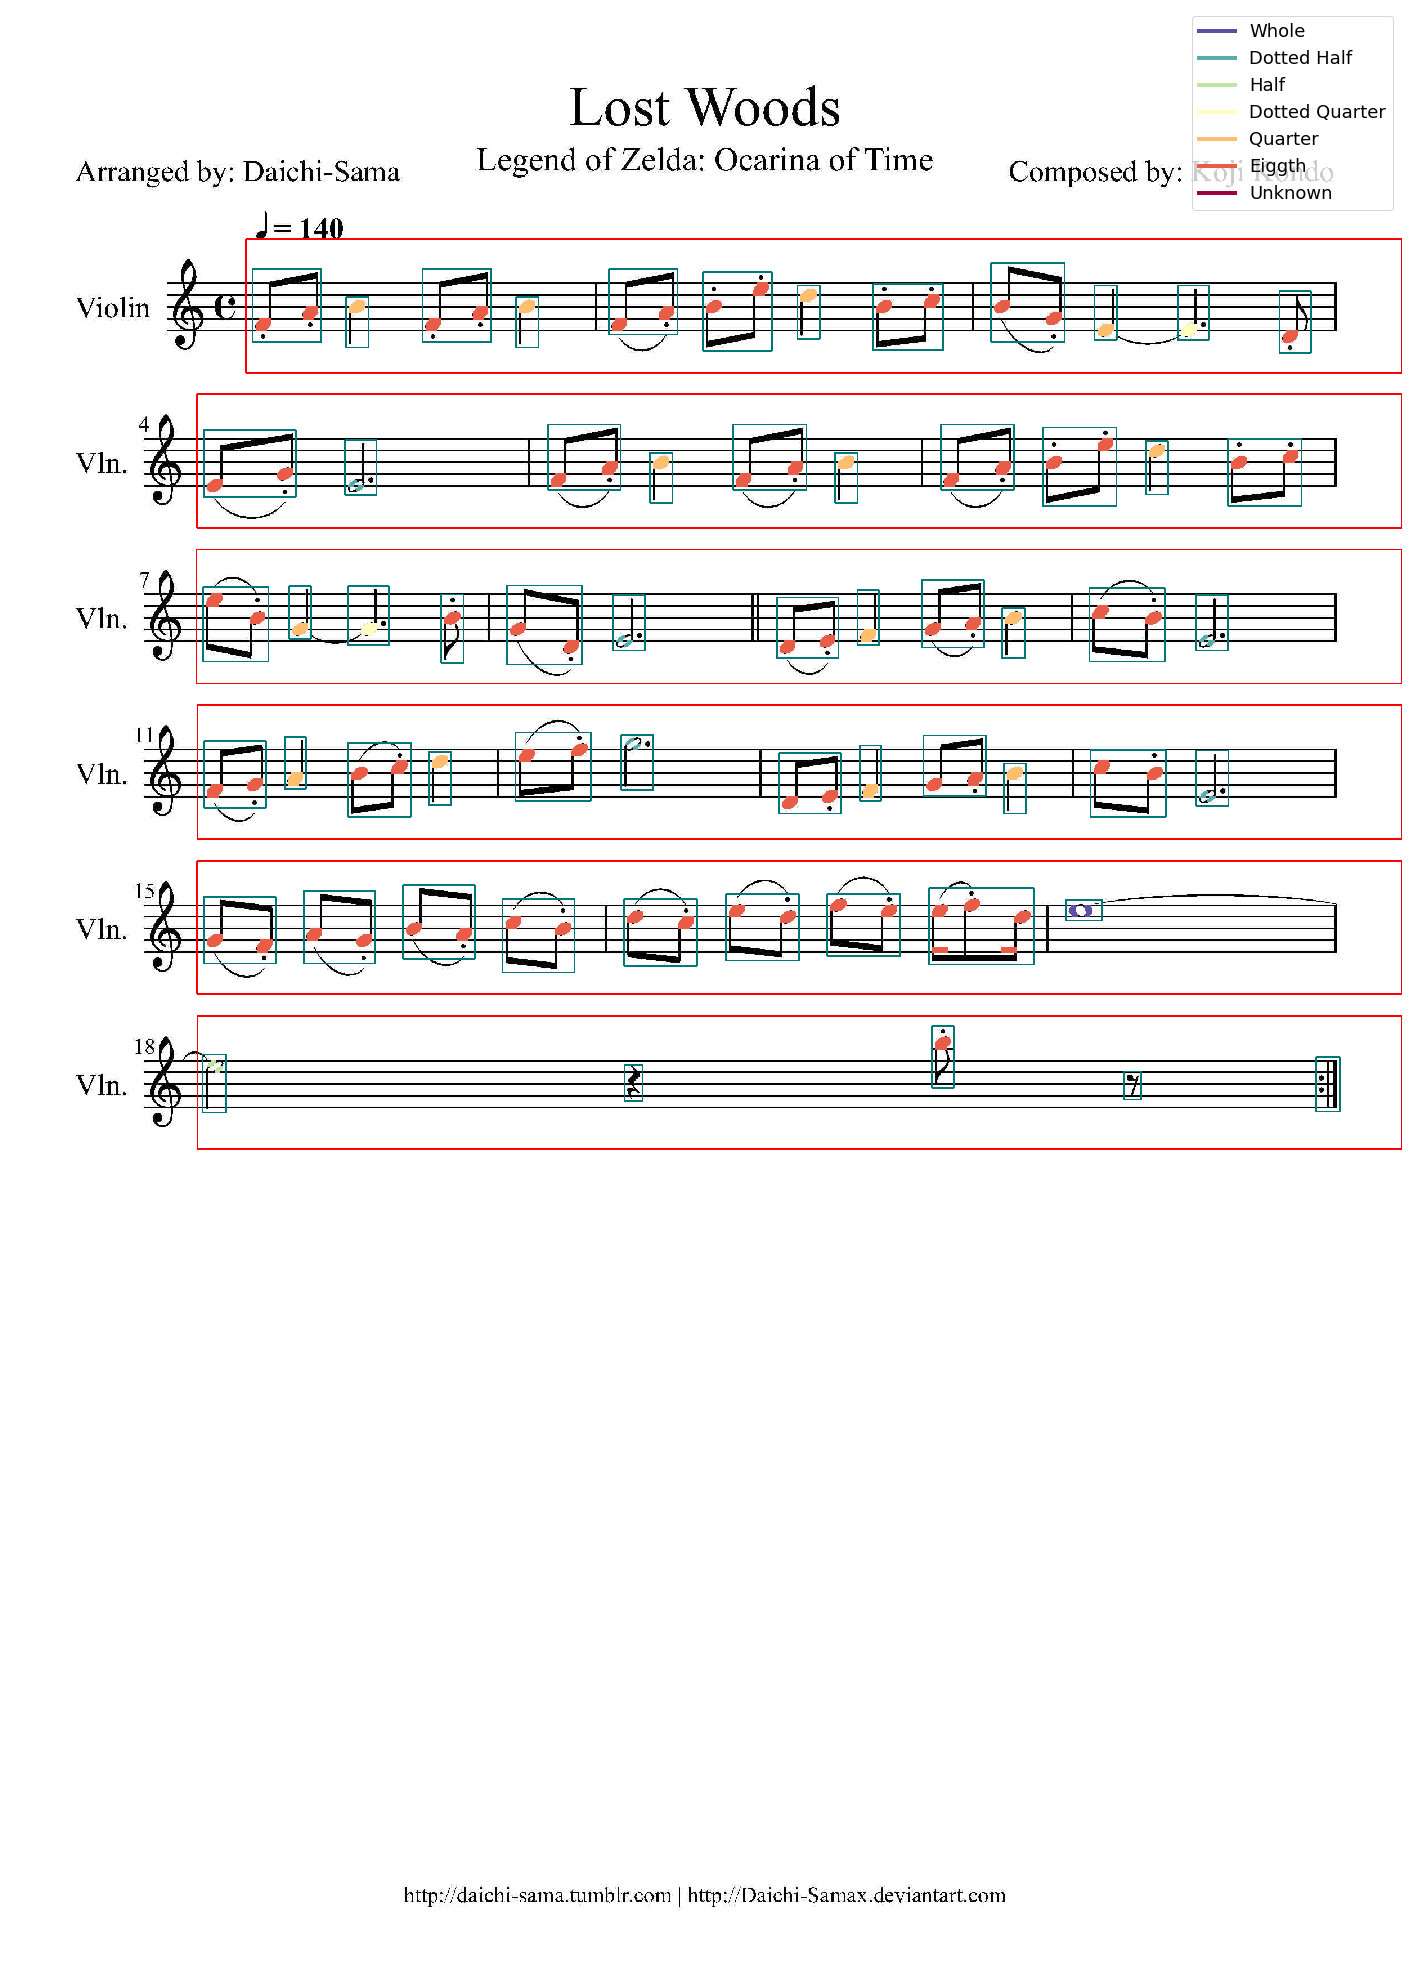

In [44]:
# Display logic
color_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
colors = np.array([plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(note_groups))])[:, :-1]*255
np.random.shuffle(colors)

head_colors = np.array([plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 7)])[:, :-1]*255

timer.start()
for index, group in enumerate(note_groups):
    for note in group.note_heads:
        color = head_colors[0]
        if note.rhythm == 0.5:
            color = head_colors[6]
        elif note.rhythm == 2/3:
            color = head_colors[5]
        elif note.rhythm == 1:
            color = head_colors[4]
        elif note.rhythm == 4/3:
            color = head_colors[3]
        elif note.rhythm == 2:
            color = head_colors[2]
        elif note.rhythm == 4:
            color = head_colors[1]
        else:
            print(f"weird rhythm: {note.rhythm}")
        color_pixels_on_image(note.pixels, color_img, color)
            
padding = 2*line_thickness
for index, group in enumerate(note_groups):
    color_bounds_on_img(group.bounds, color_img, padding=padding, color=(0, 120, 120))

draw_zones_on_image(color_img, zones_with_notes)
timer.lap(f"Drew a total of {len(note_groups)} groups")


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 40))

ax.imshow(color_img, cmap="Greys_r")
ax.axis("off")
ax.legend(['A simple line'])

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=head_colors[6]/255, lw=4),
                Line2D([0], [0], color=head_colors[5]/255, lw=4),
                Line2D([0], [0], color=head_colors[4]/255, lw=4),
                Line2D([0], [0], color=head_colors[3]/255, lw=4),
                Line2D([0], [0], color=head_colors[2]/255, lw=4),
                Line2D([0], [0], color=head_colors[1]/255, lw=4),
                Line2D([0], [0], color=head_colors[0]/255, lw=4)]
ax.legend(custom_lines, ['Whole', 'Dotted Half', 'Half', 'Dotted Quarter', 'Quarter', 'Eiggth', 'Unknown'], prop={'size': 18})

timer.stop(f"Image rendering is done")


In [45]:
notes_by_zone = groups_to_notes_by_zone(note_groups, interest_zones)

In [46]:
timer.start()
note_succession = save_notes_to_midi_files(notes_by_zone)
timer.stop("Saved notes to midi files")

play_midi()

Saved notes to midi files - 2.84ms


In [47]:
stop_midi()